In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

In [2]:
# Set device to mps or cuda if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change as needed
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [3]:
# Step 1: Load Dataset and Model
# Use IMDB dataset and a lightweight model for simplicity
model_name = "distilbert-base-uncased"
model_name = "microsoft/deberta-v3-base"
model = (
    AutoModel.from_pretrained(model_name, output_hidden_states=True).eval().to(device)
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load IMDB dataset (small subset for PoC)
dataset = load_dataset("imdb", split="test").shuffle(seed=42).select(range(10000))

/opt/miniconda3/envs/BayesianDL/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
dataset
positive_count = sum(dataset["label"])
negative_count = len(dataset) - positive_count

print(f"Number of positive samples: {positive_count}")
print(f"Number of negative samples: {negative_count}")

Number of positive samples: 4996
Number of negative samples: 5004


In [4]:
# Step 2: Format Dataset and Tokenize
def format_prompt(text, label):
    """Formats text into a yes/no prompt."""
    return f"The sentiment of this review is {'positive' if label == 1 else 'negative'}: {text}"


def tokenize_prompt(text):
    """Tokenizes the text and moves tensors to GPU."""
    return tokenizer(
        text, truncation=True, padding="max_length", max_length=128, return_tensors="pt"
    ).to(device)

In [5]:
# Step 3: Extract Hidden States
def extract_hidden_states(model, tokenizer, text, layer=-1):
    """Extract hidden states from a specific model layer."""
    inputs = tokenize_prompt(text)
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states[layer]  # Get specified layer
    return hidden_states[:, 0, :].cpu().numpy()  # CLS token representation

In [6]:
# Step 4: Generate Contrastive Pairs
neg_hs, pos_hs, labels = [], [], []
for item in tqdm(dataset):
    text, label = item["text"], item["label"]
    neg_text = format_prompt(text, label=0)
    pos_text = format_prompt(text, label=1)
    neg_hs.append(extract_hidden_states(model, tokenizer, neg_text))
    pos_hs.append(extract_hidden_states(model, tokenizer, pos_text))
    labels.append(label)


neg_hs = np.vstack(neg_hs)
pos_hs = np.vstack(pos_hs)
labels = np.array(labels)

100%|██████████| 10000/10000 [06:46<00:00, 24.62it/s]


In [7]:
# let's create a simple 50/50 train split (the data is already randomized)
n = len(dataset)
neg_hs_train, neg_hs_test = neg_hs[: n // 2], neg_hs[n // 2 :]
pos_hs_train, pos_hs_test = pos_hs[: n // 2], pos_hs[n // 2 :]
y_train, y_test = labels[: n // 2], labels[n // 2 :]

# for simplicity we can just take the difference between positive and negative hidden states
# (concatenating also works fine)
x_train = neg_hs_train - pos_hs_train
x_test = neg_hs_test - pos_hs_test

lr = LogisticRegression(class_weight="balanced")
lr.fit(x_train, y_train)
print("Logistic regression accuracy: {}".format(lr.score(x_test, y_test)))

Logistic regression accuracy: 0.862


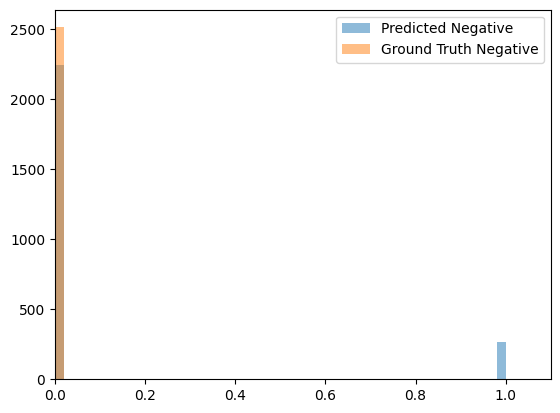

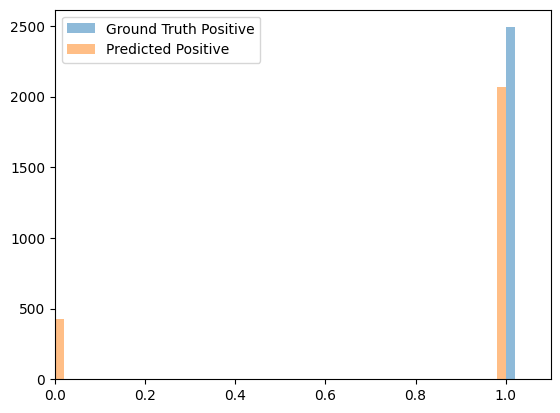

In [27]:
plt.hist(
    lr.predict(x_test[y_test == 0]), bins=50, alpha=0.5, label="Predicted Negative"
)
plt.hist(y_test[y_test == 0], bins=50, alpha=0.5, label="Ground Truth Negative")
plt.xlim(0, 1.1)
plt.legend()
plt.show()

plt.hist(y_test[y_test == 1], bins=50, alpha=0.5, label="Ground Truth Positive")

plt.hist(
    lr.predict(x_test[y_test == 1]), bins=50, alpha=0.5, label="Predicted Positive"
)
plt.legend()
plt.xlim(0, 1.1)
plt.show()

In [9]:
# NOTE CCS IS NOT IMPLEMENTED, THIS IS JUST A VERY BASIC 2-LAYER FEEDFORWARD NETWORK
# Step 5: CCS Probe Implementation
class CCSProbe(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, 128)
        self.linear2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return torch.sigmoid(self.linear2(x))


# Initialize and Train CCS Probe (CPU Version)
def train_ccs(x_train, y_train, epochs=100, lr=1e-3):
    """Train the CCS probe to differentiate contrastive pairs on CPU."""
    x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
    probe = CCSProbe(x_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(probe.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        p_train = probe(x_train)

        # CCS Loss Function
        loss = F.binary_cross_entropy(p_train, y_train)
        loss.backward()
        optimizer.step()

    return probe


# Train the CCS Probe
probe = train_ccs(x_train, y_train)

# Step 6: Visualize Output Probabilities
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
    p_test = probe(x_test_tensor).cpu().detach().numpy()

    p_combined = p_test

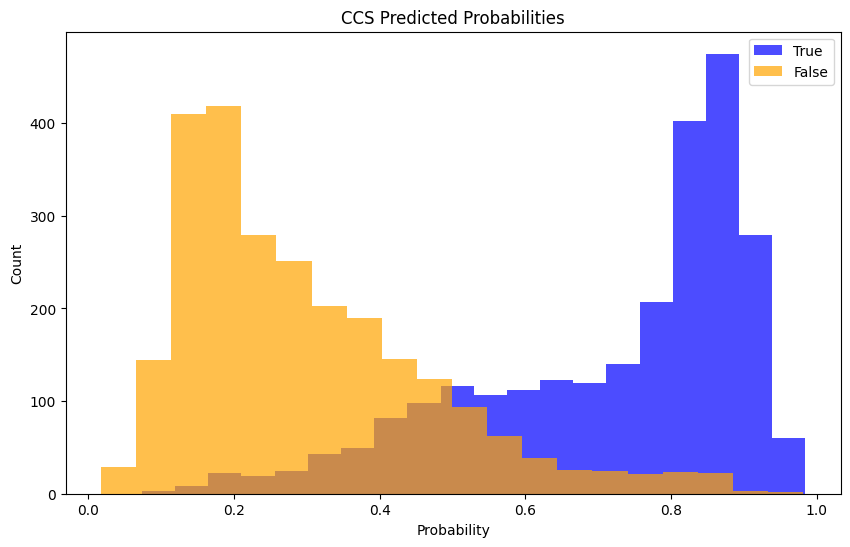

CCS Probe accuracy: 0.8584


In [11]:
from sklearn.metrics import accuracy_score

# Plot probabilities
plt.figure(figsize=(10, 6))
plt.hist(p_combined[y_test == 1], bins=20, alpha=0.7, label="True", color="blue")
plt.hist(p_combined[y_test == 0], bins=20, alpha=0.7, label="False", color="orange")

plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.title("CCS Predicted Probabilities")
plt.show()
# Compute the score
predictions = (p_combined > 0.5).astype(int)
accuracy = accuracy_score(y_test, predictions)
print("CCS Probe accuracy: {}".format(accuracy))